#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Шаги исследования

1. Подготовка данных
2. Анализ данных
3. Обучение моделей
4. Тестирование

## 1. Подготовка данных

In [1]:
# Импорт нужных библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split, 
    TimeSeriesSplit
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

RANDOM_STATE = 12345

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
# Выгрузим данные и сделаем ресемплирование по одному часу
data = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
data = data.resample('1H').sum()

**Выводы:**
- Загрузили данные;
- Сделали ресемплирование по одному часу.

## 2. Анализ данных

In [3]:
# Изучим получившийся датасет
def about_data(data):
    display(data.head(10))
    display(data.tail(10))
    display(data.info())
    display(data.describe())
    
about_data(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


,num_orders
datetime,
2018-08-31 14:00:00,133
2018-08-31 15:00:00,116
2018-08-31 16:00:00,197
2018-08-31 17:00:00,217
2018-08-31 18:00:00,207
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [4]:
# Проверили монотонность индекса
data.index.is_monotonic

True

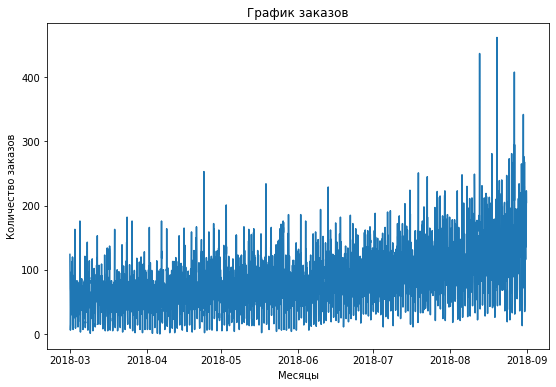

In [5]:
# Изобразим на графике временной ряд
plt.figure(figsize=(9,6))

plt.plot(data.index, data['num_orders'])
plt.title('График заказов')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')

plt.show()

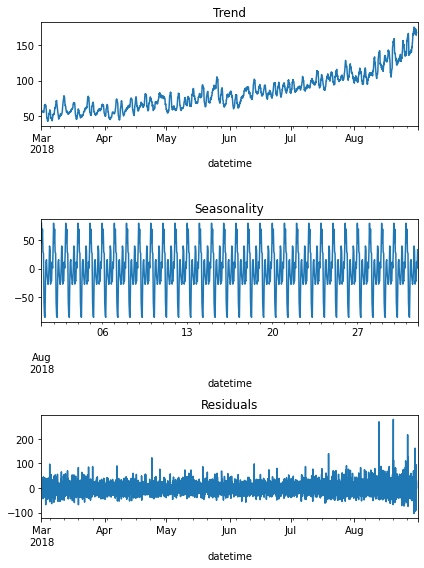

In [6]:
# Разложим временной ряд на тренд, сезонность и остаток
decomposed = seasonal_decompose(data)

decomposed_for_seasonality = seasonal_decompose(data['2018-08-01':'2018-08-31'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_for_seasonality.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

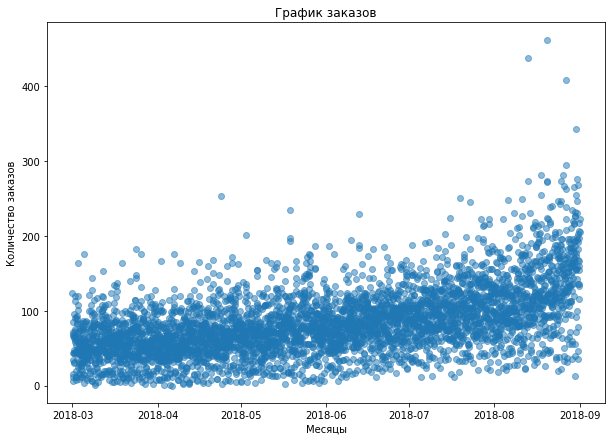

In [7]:
# Изобразим на графике распределние
plt.figure(figsize=(10,7))

plt.scatter(data.index, data['num_orders'], alpha=0.5)
plt.title('График заказов')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')

plt.show()

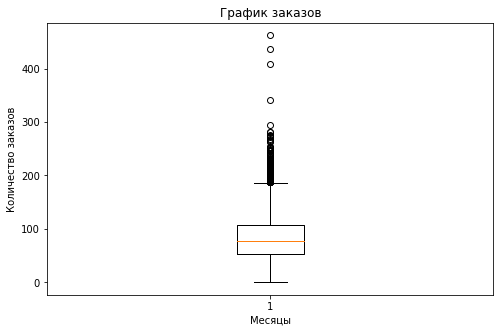

In [8]:
# Изобразим ящик с усами

plt.figure(figsize=(8,5))

plt.boxplot(data)
plt.title('График заказов')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')

plt.show()

In [9]:
# Функция для создания признаков: календарные, "отстающие значения", скользящее среднее
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day 
    data['dayofweek'] = data.index.dayofweek 
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [10]:
# Применим функцию к датасету и перезапишем его
data = make_features(data, 24, 48)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4368 non-null   int64  
 1   day           4368 non-null   int64  
 2   dayofweek     4368 non-null   int64  
 3   lag_1         4368 non-null   float64
 4   lag_2         4368 non-null   float64
 5   lag_3         4368 non-null   float64
 6   lag_4         4368 non-null   float64
 7   lag_5         4368 non-null   float64
 8   lag_6         4368 non-null   float64
 9   lag_7         4368 non-null   float64
 10  lag_8         4368 non-null   float64
 11  lag_9         4368 non-null   float64
 12  lag_10        4368 non-null   float64
 13  lag_11        4368 non-null   float64
 14  lag_12        4368 non-null   float64
 15  lag_13        4368 non-null   float64
 16  lag_14        4368 non-null   float64
 17  lag_15        4368 non-null

**Выводы**: 
- Проверили монотонность индексов;
- Визуализировали данные тремя способами (график, скаттер, боксплот);
- Разложили временной ряд на тренд, сезонность и остаток;
- Можно констатировать, что этот временной ряд **нестационарен** - его среднее растет, количество заказов неизменно увеличивается;
- В данных есть аномальные значения;
- Создали новые признаки.

## 3. Обучение моделей

In [11]:
# Поделим выборку на обучающую и тестовую 
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [12]:
# Разделим фичи и таргеты
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [13]:
# Масштабируем обучающую выборку
scaler = StandardScaler()
scaler.fit_transform(features_train)

array([[-1.39617062,  0.98530485, -0.16987555, ...,  1.10110764,
         0.31258244, -1.00546523],
       [-1.39617062,  0.98530485,  2.17910204, ..., -0.08159473,
         1.10104193, -0.960992  ],
       [-1.39617062,  0.98530485,  0.75939031, ..., -0.37069975,
        -0.08164731, -0.9347642 ],
       ...,
       [-0.2595375 , -1.4978554 ,  2.48885732, ...,  0.96969626,
         1.96834737,  2.54555079],
       [-0.2595375 , -1.4978554 ,  1.68865617, ..., -0.00274791,
         0.96963201,  2.51134061],
       [-0.2595375 , -1.4978554 ,  1.89515969, ...,  0.10238119,
        -0.00280136,  2.54555079]])

**CatBoostRegressor**

In [14]:
%%time

tscv = TimeSeriesSplit(n_splits=8) # Создали объект типа TimeSeriesSplit

params = {'n_estimators': [20, 30, 40], # Гиперпараметры
          'depth': [6, 8, 10, 12, 14]}

cat = CatBoostRegressor(loss_function='RMSE', verbose=False) 
grid = GridSearchCV(cat, params, cv=tscv, scoring = "neg_mean_squared_error", n_jobs=-1)
grid.fit(features_train, target_train)
print("Лучшие параметры:", grid.best_params_)
print("Лучшее значение метрики RMSE:", round((-grid.best_score_)**0.5, 2))

Лучшие параметры: {'depth': 8, 'n_estimators': 20}
Лучшее значение метрики RMSE: 26.27
CPU times: user 12min 37s, sys: 26.1 s, total: 13min 4s
Wall time: 14min 23s


**LGBMRegressor**

In [15]:
%%time

params_l = {'n_estimators': [10, 30], 
            'learning_rate': [0.1, 0.2, 0.3]}

lgbm = LGBMRegressor() 

clf = GridSearchCV(lgbm, params_l, cv=tscv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:", clf.best_params_)
print("Лучшее значение метрики RMSE:", round((-clf.best_score_)**0.5, 2))

Лучшие параметры: {'learning_rate': 0.2, 'n_estimators': 30}
Лучшее значение метрики RMSE: 25.76
CPU times: user 2min 44s, sys: 1.77 s, total: 2min 46s
Wall time: 2min 47s


In [20]:
index = ['CatBoostRegressor', 
         'LGBMRegressor']
final_data = {'Значение метрики RMSE на кросс-валидации (TimeSeriesSplit)': [round((-grid.best_score_)**0.5, 2), 
                                                           round((-clf.best_score_)**0.5, 2)]}
scores_data = pd.DataFrame(data=final_data, index=index)
scores_data

,Значение метрики RMSE на кросс-валидации (TimeSeriesSplit)
CatBoostRegressor,26.27
LGBMRegressor,25.76


## 4. Тестирование

LGBMRegressor
Значение метрики RMSE на тестовой выборке: 43.69
CPU times: user 59.3 ms, sys: 7.61 ms, total: 67 ms
Wall time: 25.6 ms


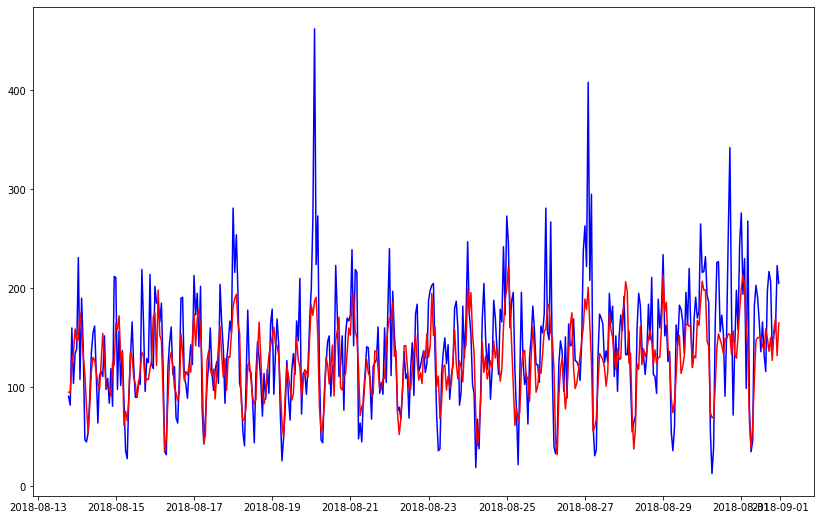

In [24]:
%%time

predicted_final_l = clf.best_estimator_.predict(features_test)
print("LGBMRegressor")
print("Значение метрики RMSE на тестовой выборке:", round(mean_squared_error(target_test, predicted_final_l)**0.5, 2))

plt.figure(figsize=(14,9))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predicted_final_l,
         'r-')

**Выводы**:
- Разделили выборку и масштабировали обучающую;
- Обучили две модели с перебором различных гиперпараметров: **CatBoostRegressor** и **LGBMRegressor**;
- Лучшая модель **LGBMRegressor** с результатом метрики RMSE на кросс-валидации равной 25.76 (у **CatBoostRegressor** - 26.27);
- Обучили **LGBMRegressor** на тестовой выборке. RMSE получилось равным **43.69**.